In [1]:
import tensorflow as tf; 
gpu_devices = tf.config.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

strategy = tf.distribute.MultiWorkerMirroredStrategy()

print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

2023-04-16 15:35:34.986959: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 15:35:35.826723: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/tensor/anaconda3/envs/tf/lib/:/lib:/home/tensor/anaconda3/envs/tf/lib/:/home/tensor/anaconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib:/home/tensor/anaconda3/envs/tf/lib/:/home/tensor/anaconda3/envs/tf/lib/python3.9/site-packages/nvidia/cudnn/lib
2023-04-16 15:35:35.826808: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library

INFO:tensorflow:Single-worker MultiWorkerMirroredStrategy with local_devices = ('/device:GPU:0', '/device:GPU:1'), communication = CommunicationImplementation.AUTO
Number of devices: 2


In [2]:
#pip install -q -U tensorflow-text==2.11.*

Model Transformer

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
import numpy as np
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time
#from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

#import tensorflow_datasets as tfds
import tensorflow_text as text
import tensorflow as tf

# Method adds the start and the end tags to the tokenized words
def add_start_end(ragged, START, END):
  count = ragged.bounding_shape()[0]
  starts = tf.fill([count,1], START) # START
  ends = tf.fill([count,1], END) # END
  return tf.concat([starts, ragged, ends], axis=1)


def cleanup_text(reserved_tokens, token_txt):
  # Drop the reserved tokens, except for "[UNK]".
  bad_tokens = [re.escape(tok) for tok in reserved_tokens if tok != "[UNK]"]
  bad_token_re = "|".join(bad_tokens)

  bad_cells = tf.strings.regex_full_match(token_txt, bad_token_re)
  result = tf.ragged.boolean_mask(token_txt, ~bad_cells)

  # Join them into strings.
  result = tf.strings.reduce_join(result, separator=' ', axis=-1)

  return result

# Custome Tokenizer class that handles all the steps for tokenizing a list of strings.
class CustomTokenizer(tf.Module):
  def __init__(self, reserved_tokens, vocab_path):
    self.tokenizer = text.BertTokenizer(vocab_path, lower_case=True)
    #self.tokenizer = text.WordpieceTokenizer(vocab_path)
    self._reserved_tokens = reserved_tokens
    self._vocab_path = tf.saved_model.Asset(vocab_path)

    vocab = pathlib.Path(vocab_path).read_text().splitlines()
    self.vocab = tf.Variable(vocab)

    ## Create the signatures for export:   

    # Include a tokenize signature for a batch of strings. 
    self.tokenize.get_concrete_function(
        tf.TensorSpec(shape=[None], dtype=tf.string))

    # Include `detokenize` and `lookup` signatures for:
    #   * `Tensors` with shapes [tokens] and [batch, tokens]
    #   * `RaggedTensors` with shape [batch, tokens]
    self.detokenize.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.detokenize.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    self.lookup.get_concrete_function(
        tf.TensorSpec(shape=[None, None], dtype=tf.int64))
    self.lookup.get_concrete_function(
          tf.RaggedTensorSpec(shape=[None, None], dtype=tf.int64))

    # These `get_*` methods take no arguments
    self.get_vocab_size.get_concrete_function()
    self.get_vocab_path.get_concrete_function()
    self.get_reserved_tokens.get_concrete_function()

  @tf.function
  def tokenize(self, strings):
    enc = self.tokenizer.tokenize(strings)
    # Merge the `word` and `word-piece` axes.
    enc = enc.merge_dims(-2,-1)

    START = tf.argmax(tf.constant(self._reserved_tokens) == "[start]")
    END = tf.argmax(tf.constant(self._reserved_tokens) == "[end]")

    enc = add_start_end(enc, START, END)
    return enc

  @tf.function
  def detokenize(self, tokenized):
    words = self.tokenizer.detokenize(tokenized)
    return cleanup_text(self._reserved_tokens, words)

  @tf.function
  def lookup(self, token_ids):
    return tf.gather(self.vocab, token_ids)

  @tf.function
  def get_vocab_size(self):
    return tf.shape(self.vocab)[0]

  @tf.function
  def get_vocab_path(self):
    return self._vocab_path

  @tf.function
  def get_reserved_tokens(self):
    return tf.constant(self._reserved_tokens)





In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import tensorflow_text as text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab

# Converts a sentence to UTF-8 format
def createSimplifiedSentence(sentence):
    #copySentence = "[start] " + sentence + " [end]"
    return sentence.encode(encoding = 'UTF-8', errors = 'strict')


def convertText(words):

    for i, sentence in enumerate(words):
      modifiedSentence = createSimplifiedSentence(sentence=sentence)
      words[i] = modifiedSentence

    return words

# Creates the vocab for the tokenizer
def createTokenizerVocab(defDS, simpDS):
  bert_tokenizer_params=dict(lower_case=True, preserve_unused_token=True)
  reserved_tokens=["[pad]", "[unk]", "[start]", "[end]"]

  bert_vocab_args = dict(
      # The target vocabulary size
      vocab_size = 30000,
      # Reserved tokens that must be included in the vocabulary
      reserved_tokens=reserved_tokens,
      # Arguments for `text.BertTokenizer`
      bert_tokenizer_params=bert_tokenizer_params,
      # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
      learn_params={},
  )

  combined = np.concatenate((defDS, simpDS))
  combinedDS = tf.data.Dataset.from_tensor_slices(combined)


  en_vocab = bert_vocab.bert_vocab_from_dataset(
    combinedDS.batch(1000).prefetch(tf.data.AUTOTUNE),
    **bert_vocab_args
  )

  write_vocab_file('ENG.txt', en_vocab)

# Method that will save the vocab file
def write_vocab_file(filepath, vocab):
  with open(filepath, 'w') as f:
    for token in vocab:
      print(token, file=f)

In [6]:
# Below we pull the data, split it into the training and test sets and create the tokenizer.

fullDs = pd.read_csv("/home/tensor/Documents/Github/child-friendly-definitions/notebooks/start/fullDataset.csv")
fullDs = fullDs.sample(frac=1)  # shuffle the dataset
fullDs = fullDs.astype(str)

length = len(fullDs)
trainRatio = int(0.9 * length)
  
x = fullDs['definition'].values[:trainRatio]
y = fullDs['simplified_definition'].values[:trainRatio]

val_x = fullDs['definition'].values[trainRatio:]
val_y = fullDs['simplified_definition'].values[trainRatio:]
# the two arrays below are tokenized and padded for thetf.data.Dataset.from_tensor_slices((full_train_x,full_train_y)) algorithm (possible to combine the two tokenizers into 1)
full_train_x = convertText(x)
full_train_y = convertText(y)

full_val_x = convertText(val_x)
full_val_y = convertText(val_y)

createTokenizerVocab(full_train_x, full_train_y)
# prepare the training data in a suitable format


In [7]:
print(len(x))
print(len(y))
print(len(val_x))
print(len(val_y))

10860
10860
1207
1207


In [8]:
# create the tokenizer
tokenizers = tf.Module()
rTokens=["[pad]", "[unk]", "[start]", "[end]"]
tokenizers.en = CustomTokenizer(rTokens, 'ENG.txt')
model_name = 'EnglishTokenizer'
tf.saved_model.save(tokenizers, model_name)

INFO:tensorflow:Assets written to: EnglishTokenizer/assets


In [9]:
tokenizer = tf.saved_model.load(model_name)
tokenizer.en.get_vocab_size()

<tf.Tensor: shape=(), dtype=int32, numpy=3286>

In [10]:
full_train_y[0]

b'a woman who is believed to have magic powers . '

In [11]:
enc = tokenizer.en.tokenize([full_train_y[0]])
enc

<tf.RaggedTensor [[2, 10, 496, 62, 47, 2068, 41, 86, 2454, 2670, 6, 3]]>

In [12]:
tokenizer.en.lookup(enc)

<tf.RaggedTensor [[b'[start]', b'a', b'woman', b'who', b'is', b'believed', b'to', b'have',
  b'magic', b'powers', b'.', b'[end]']]>

In [13]:
dec = tokenizer.en.detokenize(enc)
dec

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'a woman who is believed to have magic powers .'], dtype=object)>

In [14]:
e = tokenizer.en.tokenize(["some random sentence"])
e

<tf.RaggedTensor [[2, 98, 27, 2021, 665, 1029, 3]]>

In [15]:
tokenizer.en.lookup(e)

<tf.RaggedTensor [[b'[start]', b'some', b'r', b'##and', b'##om', b'sentence', b'[end]']]>

In [16]:
tokenizer.en.detokenize(e)

<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'some random sentence'], dtype=object)>

In [17]:
ds = tf.data.Dataset.from_tensor_slices((full_train_x,full_train_y))
ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

In [18]:
val_ds = tf.data.Dataset.from_tensor_slices((full_val_x, full_val_y))
val_ds

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))>

Testing dataset for each layer

In [19]:
# Method generate a batch of sentences when the model wants it.
MAX_TOKENS=200
def prepare_batch(DEF, SIMPDEF):
    DEF = tokenizer.en.tokenize(DEF)      # Output is ragged.
    DEF = DEF[:, :MAX_TOKENS]    # Trim to MAX_TOKENS.
    DEF = DEF.to_tensor()  # Convert to 0-padded dense Tensor

    SIMPDEF = tokenizer.en.tokenize(SIMPDEF)
    SIMPDEF = SIMPDEF[:, :(MAX_TOKENS+1)]
    SIMPDEF_inputs = SIMPDEF[:, :-1].to_tensor()  # Drop the [END] tokens
    SIMPDEF_labels = SIMPDEF[:, 1:].to_tensor()   # Drop the [START] tokens

    return (DEF, SIMPDEF_inputs), SIMPDEF_labels

In [20]:
BUFFER_SIZE = 20000
BATCH_SIZE = 16

def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))
  
batches = make_batches(ds) # test
batches # if it prints it works

<PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None)), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [21]:
val_batches = make_batches(val_ds)

In [22]:
for (DEF, SIMP), SIMP_labels in batches.take(1):
  break

print(DEF.shape)
print(SIMP.shape)
print(SIMP_labels.shape)

(16, 28)
(16, 41)
(16, 41)


Defining Components of Transformer

Input/Output embedding + Encoding

In [23]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)
  
  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1) 

  return tf.cast(pos_encoding, dtype=tf.float32)

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [25]:
embed_DEF = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)
embed_SIMP = PositionalEmbedding(vocab_size=tokenizers.en.get_vocab_size(), d_model=512)

DEF_emb = embed_DEF(DEF)
SIMP_emb = embed_SIMP(SIMP)
SIMP_emb._keras_mask

<tf.Tensor: shape=(16, 41), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False

BaseAttention Layer (Multi-Head Attention + add & Norm)

In [26]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

Cross Attention Layer (Base Attention Layer where the encoder meets the decoder)

In [27]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query=x,
        key=context,
        value=context,
        return_attention_scores=True)
   
    # Cache the attention scores for plotting later.
    self.last_attn_scores = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [28]:
sample_ca = CrossAttention(num_heads=2, key_dim=512)

print(DEF_emb.shape)
print(SIMP_emb.shape)
print(sample_ca(SIMP_emb, DEF_emb).shape)

(16, 28, 512)
(16, 41, 512)
(16, 41, 512)


Global Self Attention (input attention)

In [29]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [30]:
sample_gsa = GlobalSelfAttention(num_heads=2, key_dim=512)

print(DEF_emb.shape)
print(sample_gsa(DEF_emb).shape)

(16, 28, 512)
(16, 28, 512)


Casual Attention Layer (Output attention)

In [31]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x,
        use_causal_mask = True)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x

In [32]:
sample_csa = CausalSelfAttention(num_heads=2, key_dim=512)

print(SIMP_emb.shape)
print(sample_csa(SIMP_emb).shape)

(16, 41, 512)
(16, 41, 512)


In [33]:
out1 = sample_csa(embed_SIMP(SIMP[:, :3])) 
out2 = sample_csa(embed_SIMP(SIMP))[:, :3]

tf.reduce_max(abs(out1 - out2)).numpy()

4.7683716e-07

Feed Forward Layer (2 Dense and an add & Norm)

In [34]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x) 
    return x

In [35]:
sample_ffn = FeedForward(512, 2048)

print(SIMP_emb.shape)
print(sample_ffn(SIMP_emb).shape)

(16, 41, 512)
(16, 41, 512)


Encoder (Not including the input embeddings)

In [36]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

In [37]:
sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

print(SIMP_emb.shape)
print(sample_encoder_layer(DEF_emb).shape)

(16, 41, 512)
(16, 28, 512)


Full Encoder Including Embeddings

In [38]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.
    
    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

In [39]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(DEF, training=False)

# Print the shape.
print(DEF.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(16, 28)
(16, 28, 512)


Decoder Without Embeddings

In [40]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

In [41]:
sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

sample_decoder_layer_output = sample_decoder_layer(
    x=SIMP_emb, context=DEF_emb)

print(SIMP_emb.shape)
print(DEF_emb.shape)
print(sample_decoder_layer_output.shape)  # `(batch_size, seq_len, d_model)`

(16, 41, 512)
(16, 28, 512)
(16, 41, 512)


Decoder With Embeddings

In [42]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size=vocab_size,
                                             d_model=d_model)
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads,
                     dff=dff, dropout_rate=dropout_rate)
        for _ in range(num_layers)]

    self.last_attn_scores = None

  def call(self, x, context):
    # `x` is token-IDs shape (batch, target_seq_len)
    x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

    x = self.dropout(x)

    for i in range(self.num_layers):
      x  = self.dec_layers[i](x, context)

    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    # The shape of x is (batch_size, target_seq_len, d_model).
    return x

In [43]:
# Instantiate the decoder.
sample_decoder = Decoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8000)

output = sample_decoder(
    x=SIMP,
    context=DEF_emb)

# Print the shapes.
print(SIMP.shape)
print(DEF_emb.shape)
print(output.shape)

(16, 41)
(16, 28, 512)
(16, 41, 512)


Full Transformer with all layers combined

In [44]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
               input_vocab_size, target_vocab_size, dropout_rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=input_vocab_size,
                           dropout_rate=dropout_rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           vocab_size=target_vocab_size,
                           dropout_rate=dropout_rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):
    # To use a Keras model with `.fit` you must pass all your inputs in the
    # first argument.
    context, x  = inputs

    context = self.encoder(context)  # (batch_size, context_len, d_model)

    x = self.decoder(x, context)  # (batch_size, target_len, d_model)

    # Final linear layer output.
    logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

    try:
      # Drop the keras mask, so it doesn't scale the losses/metrics.
      # b/250038731
      del logits._keras_mask
    except AttributeError:
      pass

    # Return the final output and the attention weights.
    return logits

Setting up the model

In [45]:
# num_layers=6, d_model=512, and dff=2048
#Hyper parameters (Tensorflow's website has more information to what parameter is associated with what)
num_layers = 6
d_model = 128
dff = 256
num_heads = 4
dropout_rate = 0.5


In [46]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Creating the optimizer and find the bets learning rate

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
with strategy.scope():
    learning_rate = CustomSchedule(d_model)

    optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Creating the masked loss (removes any weights that the padding may have)

Fit the model

In [48]:
inputVocabSize = tokenizers.en.get_vocab_size().numpy()
outputVocabSize = inputVocabSize
#tf.placeholder
with strategy.scope():
    transformer = Transformer(
        num_layers=num_layers,
        d_model=d_model,
        num_heads=num_heads,
        dff=dff,
        input_vocab_size=inputVocabSize, # this has been changed
        target_vocab_size=outputVocabSize, # this has been changed
        dropout_rate=dropout_rate)
    transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])
    
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            filepath="model.hs",
            save_best_only=True,
            monitor="val_loss")
]
    history = transformer.fit(batches,
                epochs=200,
                validation_data=val_batches)

2023-04-16 15:36:03.889796: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 10860
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
   

Epoch 1/200
INFO:tensorflow:Collective all_reduce tensors: 254 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce IndexedSlices: 2 all_reduces, num_devices =2, group_size = 2, implementation = CommunicationImplementation.AUTO
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduc

2023-04-16 15:38:39.457592: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:784] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1207
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:6"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
    

INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
INFO:tensorflow:Collective all_reduce tensors: 1 all_reduces, num_devices = 2, group_size = 2, implementation = CommunicationImplementation.AUTO, num_packs = 1
679/679 [==============================] - 163s 158ms/step - loss: 6.4213 - masked_accuracy: 0.1349 - val_loss: 5.4183 - val_masked_accuracy: 0.1921
Epoch 2/200
679/679 [==============================] - 87s 129ms/step - loss: 5.1427 - masked_accuracy: 0.2098 - val_loss: 4.8537 - val_masked_accuracy: 0.2203
Epoch 3/200
679/679 [==============================

679/679 [==============================] - 85s 125ms/step - loss: 2.9583 - masked_accuracy: 0.3799 - val_loss: 3.7516 - val_masked_accuracy: 0.3305
Epoch 49/200
679/679 [==============================] - 85s 125ms/step - loss: 2.9452 - masked_accuracy: 0.3811 - val_loss: 3.7738 - val_masked_accuracy: 0.3299
Epoch 50/200
679/679 [==============================] - 85s 125ms/step - loss: 2.9379 - masked_accuracy: 0.3820 - val_loss: 3.7829 - val_masked_accuracy: 0.3287
Epoch 51/200
679/679 [==============================] - 83s 123ms/step - loss: 2.9289 - masked_accuracy: 0.3841 - val_loss: 3.7789 - val_masked_accuracy: 0.3302
Epoch 52/200
679/679 [==============================] - 79s 116ms/step - loss: 2.9152 - masked_accuracy: 0.3844 - val_loss: 3.7598 - val_masked_accuracy: 0.3331
Epoch 53/200
679/679 [==============================] - 79s 116ms/step - loss: 2.9079 - masked_accuracy: 0.3859 - val_loss: 3.7931 - val_masked_accuracy: 0.3319
Epoch 54/200
679/679 [=========================

Epoch 99/200
679/679 [==============================] - 78s 115ms/step - loss: 2.6035 - masked_accuracy: 0.4287 - val_loss: 3.7869 - val_masked_accuracy: 0.3404
Epoch 100/200
679/679 [==============================] - 79s 116ms/step - loss: 2.5960 - masked_accuracy: 0.4305 - val_loss: 3.8048 - val_masked_accuracy: 0.3412
Epoch 101/200
679/679 [==============================] - 81s 119ms/step - loss: 2.5925 - masked_accuracy: 0.4311 - val_loss: 3.8094 - val_masked_accuracy: 0.3378
Epoch 102/200
679/679 [==============================] - 80s 118ms/step - loss: 2.5940 - masked_accuracy: 0.4303 - val_loss: 3.7996 - val_masked_accuracy: 0.3312
Epoch 103/200
679/679 [==============================] - 80s 118ms/step - loss: 2.5843 - masked_accuracy: 0.4326 - val_loss: 3.7960 - val_masked_accuracy: 0.3400
Epoch 104/200
679/679 [==============================] - 80s 118ms/step - loss: 2.5798 - masked_accuracy: 0.4317 - val_loss: 3.7962 - val_masked_accuracy: 0.3427
Epoch 105/200
679/679 [======

679/679 [==============================] - 85s 125ms/step - loss: 2.4198 - masked_accuracy: 0.4580 - val_loss: 3.8875 - val_masked_accuracy: 0.3323
Epoch 150/200
679/679 [==============================] - 84s 124ms/step - loss: 2.4169 - masked_accuracy: 0.4585 - val_loss: 3.8468 - val_masked_accuracy: 0.3476
Epoch 151/200
679/679 [==============================] - 84s 124ms/step - loss: 2.4113 - masked_accuracy: 0.4599 - val_loss: 3.8595 - val_masked_accuracy: 0.3417
Epoch 152/200
679/679 [==============================] - 84s 124ms/step - loss: 2.4093 - masked_accuracy: 0.4584 - val_loss: 3.8505 - val_masked_accuracy: 0.3461
Epoch 153/200
679/679 [==============================] - 84s 124ms/step - loss: 2.4088 - masked_accuracy: 0.4583 - val_loss: 3.8523 - val_masked_accuracy: 0.3430
Epoch 154/200
679/679 [==============================] - 84s 123ms/step - loss: 2.4043 - masked_accuracy: 0.4607 - val_loss: 3.8457 - val_masked_accuracy: 0.3441
Epoch 155/200
679/679 [===================

679/679 [==============================] - 85s 125ms/step - loss: 2.2964 - masked_accuracy: 0.4775 - val_loss: 3.8830 - val_masked_accuracy: 0.3458
Epoch 200/200
679/679 [==============================] - 85s 125ms/step - loss: 2.2905 - masked_accuracy: 0.4784 - val_loss: 3.9365 - val_masked_accuracy: 0.3435


In [49]:
#testing the model
output = transformer((DEF, SIMP))


print(SIMP.shape)
print(DEF.shape)
print(output.shape)

(16, 41)
(16, 28)
(16, 41, 3286)


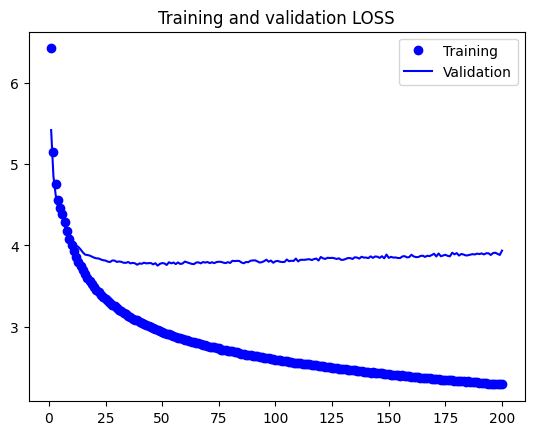

<Figure size 640x480 with 0 Axes>

In [50]:
import matplotlib.pyplot as plt
accuracy = history.history["loss"]
val_accuracy = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training")
plt.plot(epochs, val_accuracy, "b", label="Validation")
plt.title("Training and validation LOSS")
plt.legend()
plt.figure()
plt.show()

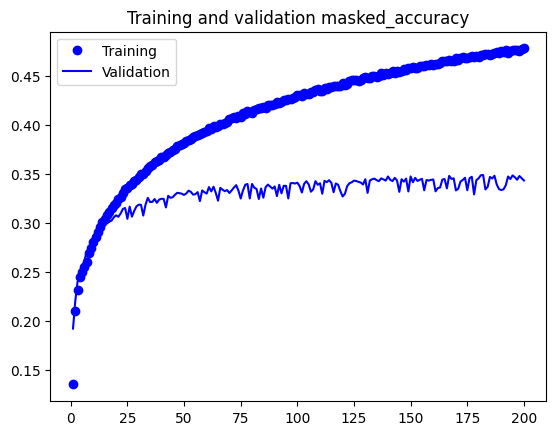

<Figure size 640x480 with 0 Axes>

In [51]:
import matplotlib.pyplot as plt
accuracy = history.history["masked_accuracy"]
val_accuracy = history.history["val_masked_accuracy"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training")
plt.plot(epochs, val_accuracy, "b", label="Validation")
plt.title("Training and validation masked_accuracy")
plt.legend()
plt.figure()
plt.show()

Predicting on New Text

In [52]:
#class to handle the predictions to the model
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    print(sentence)
    print(max_length)
    
    # The input sentence is Portuguese, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.en.tokenize(sentence)
    print(sentence)
    sentence = sentence.to_tensor()

    encoder_input = sentence

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.en.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]
    print("Start: " + str(start))
    print("End: " + str(end))

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.en.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.en.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [53]:
translator = Translator(tokenizer, transformer)

Exporting

In [54]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [55]:
translator = ExportTranslator(translator)

Random Predictions (Hopefully Works)

In [56]:
translator("a supposition or proposed explanation made on the basis of limited evidence as a starting point for further investigation.").numpy()

Tensor("sentence:0", shape=(), dtype=string)
200
tf.RaggedTensor(values=Tensor("StatefulPartitionedCall:0", shape=(None,), dtype=int64), row_splits=Tensor("StatefulPartitionedCall:1", shape=(None,), dtype=int64))
Start: Tensor("strided_slice_2:0", shape=(1,), dtype=int64)
End: Tensor("strided_slice_4:0", shape=(1,), dtype=int64)


b'a person who is very great deal about something .'

In [57]:
sentence = x[0]
translator(sentence).numpy()

b'a person who is very great deal about something .'

In [58]:
x[0]

b'one who exercises more than common power of attraction '